In [1]:
import sys
sys.path.append('/home/ubuntu/tormography/src')

import os
import torch
import torch.nn as nn
from torchvision.transforms.functional import rotate
from torchvision.transforms import InterpolationMode
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook'])
from pytomography.algorithms import OSEMOSL, OSEMBSR
from pytomography.priors import QuadraticPrior, LogCoshPrior, QClearPrior
from pytomography.metadata import ObjectMeta, ImageMeta, PSFMeta
from pytomography.corrections import CTCorrectionNet, PSFCorrectionNet
from pytomography.projections import ForwardProjectionNet, BackProjectionNet
from pytomography.callbacks import CallBack
from pytomography.io import simind_CT_to_data, simind_projections_to_data
from scipy.ndimage import zoom, affine_transform
import cv2
from skimage.measure import label, regionprops, regionprops_table
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cuda'

In [2]:
path = '/home/ubuntu/tormography/test_files/quantitative'

The purpose of this tutorial is to explore a full quantitative evaluation of various reconstruction methods using PyTomography. In this tutorial, we'll make use of a ground truth phantom and corresponding projection data obtained using SIMIND.

## Part 1: Setting Up The Phantom

Firstly, we'll open the ground truth phantom

In [3]:
GT = np.fromfile(os.path.join(path,'body1_Lu177_T1.bin'), dtype=np.float32)
GT.shape

(196870144,)

We'll need to reshape it into a 3D array. In this case, I know that the shape of the phantom is (751x512x512) because I created it as such.

In [4]:
GT = GT.reshape((751,512,512))

Now we should make sure the axes align with pytomography standards (`axis=0` is x, `axis=1` is y, and `axis=2` is z). The data was saved in the opposite order, so I need to transpose it.

In [5]:
GT = np.transpose(GT, (2,1,0))
GT = np.pad(GT, ((0,0),(0,0),(8,8)))

Now we can plot it. Let's look at a $x-z$ maximum intensity projection of the phantom.

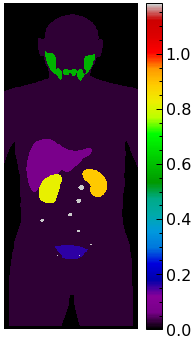

In [6]:
plt.figure(figsize=(3,6))
plt.pcolormesh(GT.max(axis=1).T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar()
plt.show()

This constitutes our ground truth; the units are MBq/mL. In a short moment, we'll open our SPECT projection data, and run our iterative reconstruction algorithm to compare the true activity in each organ to the reconstructed object's activity as a function of iteration number. To do this, we'll need masks for each organ.

* It very well may be the case that the ground truth object is of different dimensions than the reconstructed object. In our case, the ground truth is of shape 512x512x751 and the reconstructed object (as we will see shortly) will be of shape 128x128x384. So long as the two objects are algined, we can simply resize the ground truth phantom so the arrays have the same dimensions.

* In this case, I know the precise activity values in each organ/lesion, so it's easy to make masks.

In [7]:
activities = {'bkg':0.0238, 'liver':0.115, 'lungs':0.0238, #body8
         'rkidcor':0.564, 'lkidcor':0.536, 'rkidmel':0.257,
         'lkidmel':0.161, 'sal':0.43, 'bla':0.311, 'les':0.633}
activities = {'bkg':0.0238, 'liver':0.0735, 'lungs':0.0238, #body1
         'rkidcor':0.822, 'lkidcor':0.89, 'rkidmel':0.398,
         'lkidmel':0.322, 'sal':0.574, 'bla':0.158, 'les':1.18}
def get_mask(arr, val, pct=1):
    arr = (arr<val+(pct/100)*val)*(arr>val-(pct/100)*val)
    arr = zoom(arr, (128/512, 128/512, 3*128/767), order=0, mode='nearest')
    return torch.tensor(arr.copy()).to(device)

This function allows me to create a mask in a region with value `val`$\pm$`pct`. For example, if I wanted a mask of the liver:

In [8]:
liver_mask = get_mask(GT, activities['liver'])
liver_mask.shape

torch.Size([128, 128, 384])

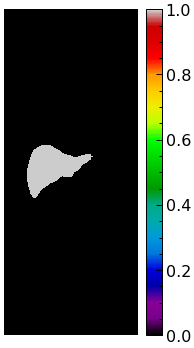

In [9]:
plt.figure(figsize=(3,6))
plt.pcolormesh(liver_mask.cpu().numpy().max(axis=1).T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar()
plt.show()

This mask will allow me to compare the true activity of the liver (0.0735MBq/mL) to the value obtained from the reconstruction in that region.

## Part 2: Getting The Calibration Factor

Since our SPECT data is measured in MBq/mL and the SPECT reconstruction will be in units of counts, we need a way to convert between units. You may be tempted to think that 1Bq = 1 count per second, but this is not true for a scan where "counts" actually means "detected counts". In general, a detector is not 100% efficient (far from it) so most radioactive counts go undetected (in SPECT, they may not be parallel with the collimators).

 Regardless, we can still get an empirical conversion factor by scanning a point source of known activity inside the scanner. Let's open some projection data corresponding to a point calibtation scan:

In [10]:
object_meta, image_meta, projections = simind_projections_to_data(os.path.join(path, 'pointcalib1.h'))

Let's look at the first projection:

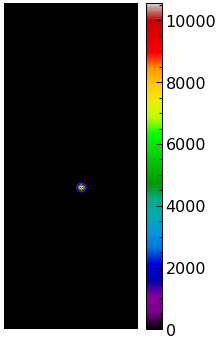

In [11]:
plt.figure(figsize=(3,6))
plt.pcolormesh(projections[0][0].T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar()
plt.show()

In [12]:
total_counts = projections[0][0].sum().item()
dV = object_meta.dr[0] * object_meta.dr[1] * object_meta.dr[2] # units: cm^3 = mL

In this case, the activity of the point source was 1700MBq, and the scan was taken for 15s. The colorbar shows the total number of detected counts. The number of MBq/mL per CPS is thus

In [55]:
CPS_to_MBQpermL = (1700/dV)/(total_counts)
CPS_to_MBQpermL

0.21089022221130554

So after reconstructing our object (which gives units of detected counts), we need to multiply by that factor to get units of MBq/mL, which we can use to compare to our phantom.

## Part 3: Reconstructing SPECT Data

Now we will reconstruct our SPECT data, and compare it to the original phantom. In particular, since we're using an iterative algorithm, we'll want to see how the improvements as a function of iterations. We'll get to that later.

First we'll open the SPECT scan

In [42]:
object_meta, image_meta, projections = simind_projections_to_data(os.path.join(path, 'body.h00'))
projections = projections.to(torch.float)

In [64]:
image_meta.radii

array([25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25.])

In [43]:
projections.shape

torch.Size([1, 120, 128, 384])

In [44]:
a=1

Text(0.5, 1.0, 'Phantom')

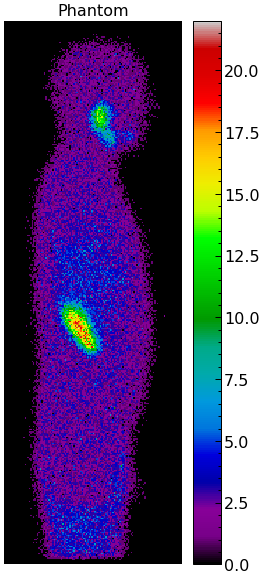

In [45]:
plt.figure(figsize=(4,10))
plt.pcolormesh(projections[0,30].cpu().numpy().T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar()
plt.title('Phantom')

Now the CT:

In [46]:
CT = simind_CT_to_data(os.path.join(path, f'body8t1new.hct')).unsqueeze(dim=0)

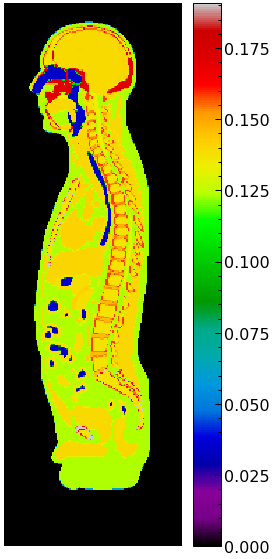

In [47]:
plt.figure(figsize=(4,10))
plt.pcolormesh(CT[0][64].cpu().numpy().T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar()

Now we'll reconstruct in a few different ways. First let's setup our PSF and CT correction networks.

* PSF modeling

In [48]:
f = 2 * np.sqrt(2*np.log(2))
collimator_slope = 0.07095 / f
collimator_intercept = 0.004632 / f
psf_meta = PSFMeta(collimator_slope, collimator_intercept, '2D')
psf_net = PSFCorrectionNet(psf_meta, device=device)

* Attenuation correction modeling

In [49]:
ct_net = CTCorrectionNet(CT, device=device)

* Priors

In [50]:
qcp = QClearPrior(beta=1, gamma=5, device=device)
qp = QuadraticPrior(beta=2, device=device)

Now we'll define  a function which automates the reconstruction process

In [51]:
class CompareToGroundTruth(CallBack):
    def __init__(self, GT, activity_dict, calibration_factor, device):
        self.device = device
        self.GT = GT
        self.calibration_factor = calibration_factor
        self.activity_dict = activity_dict
        self.organ_keys = activity_dict.keys()
        self.mask_dict = {key: self.get_mask(activity_dict[key]) for key in self.organ_keys}
        self.biass = {key: [] for key in self.organ_keys}
        self.vars = {key: [] for key in self.organ_keys}
        self.vals = {key: [] for key in self.organ_keys}
    def get_mask(self, val, pct=1):
        arr = (self.GT<val+(pct/100)*val)*(self.GT>val-(pct/100)*val)
        arr = zoom(arr, (128/512, 128/512, 384/767), order=0, mode='nearest')
        return torch.tensor(arr.copy()).unsqueeze(dim=0).to(self.device)
    def run(self, obj):
        obj_cal = obj *self.calibration_factor
        for key in self.organ_keys:
            self.biass[key].append(torch.mean(obj_cal[self.mask_dict[key]] - self.activity_dict[key]).item())
            self.vars[key].append(torch.var(obj_cal[self.mask_dict[key]] - self.activity_dict[key]).item())
            self.vals[key].append(torch.mean(obj_cal[self.mask_dict[key]]).item())

def reconstruct_object(callback, n_iters, n_subsets, prior, object_correction_nets, image_correction_nets):
    fp_net = ForwardProjectionNet(object_correction_nets, image_correction_nets,
                                object_meta, image_meta, device=device)
    bp_net = BackProjectionNet(object_correction_nets, image_correction_nets,
                                object_meta, image_meta, device=device)
    object_initial = torch.ones((1,128,128,384)).to(device)
    osem_net = OSEMBSR(object_initial, fp_net, bp_net, prior=prior)
    osem_net.set_image(projections)
    return osem_net(n_iters, n_subsets, callback=callback)

In [60]:
stats_generic = CompareToGroundTruth(GT, activities, calibration_factor=CPS_to_MBQpermL, device=device)
# stats_qclear = CompareToGroundTruth(GT, activities, calibration_factor=CPS_to_MBQpermL, device=device)

In [61]:
reconstructed_object = reconstruct_object(stats_generic, 2, 4, None, [ct_net, psf_net], [])
# reconstructed_object_qclear = reconstruct_object(stats_qclear, 10, 8, qcp, [ct_net, psf_net], [])

/tmp/ipykernel_16156/1963065054.py:15: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar()


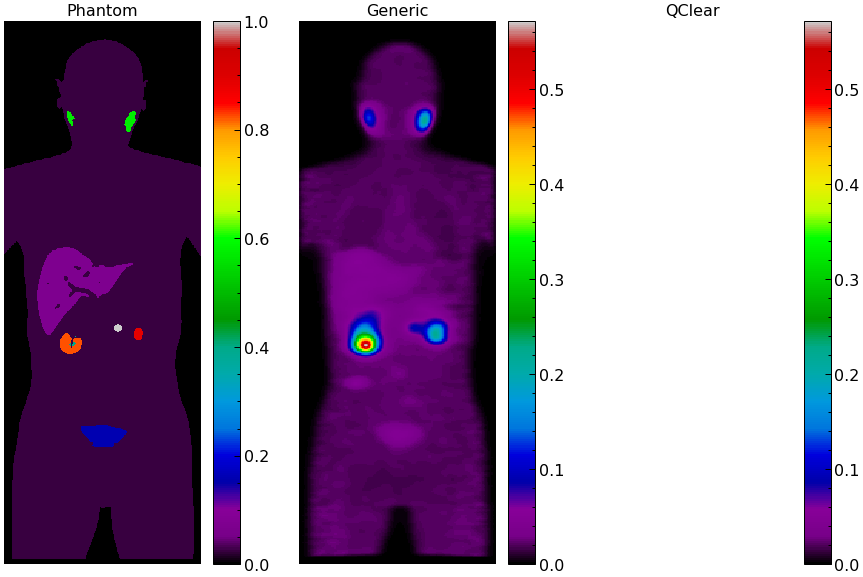

In [63]:
plt.subplots(1,3,figsize=(15,10))
plt.subplot(131)
plt.pcolormesh(GT[:,256].T, cmap='nipy_spectral', vmax=1)
plt.axis('off')
plt.colorbar()
plt.title('Phantom')
plt.subplot(132)
plt.pcolormesh(reconstructed_object[0][:,64].cpu().numpy().T*CPS_to_MBQpermL, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar()
plt.title('Generic')
plt.subplot(133)
# plt.pcolormesh(reconstructed_object_qclear[0][:,64].cpu().numpy().T*CPS_to_MBQpermL, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar()
plt.title('QClear')

plt.show()


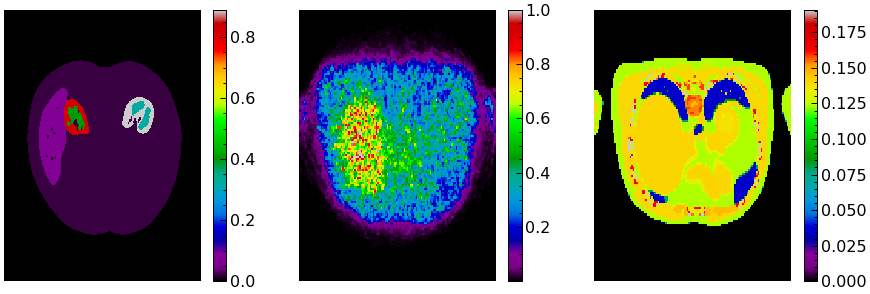

In [40]:
plt.subplots(1,3,figsize=(15,5))
plt.subplot(131)
plt.pcolormesh(GT[:,:,352].T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar()
plt.subplot(132)
plt.pcolormesh(reconstructed_object[0][:,:,210].cpu().numpy().T*CPS_to_MBQpermL, cmap='nipy_spectral', vmax=1)
plt.axis('off')
plt.colorbar()
plt.subplot(133)
plt.pcolormesh(CT[0][:,:,210].cpu().numpy().T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar()

Here's a little plotting script to show bias variance curves

In [ ]:
def plot_bvc(statistics, organ, ax, color, label):
    ax.plot(np.abs(statistics.biass[organ])/activities[organ] *100, np.sqrt(statistics.vars[organ])/activities[organ] * 100, ls='--', marker='o', markersize=4, lw=2, color=color, label=label)
    
title_dict = {'bkg': 'Background', 'liver': 'Liver', 'lungs': 'Lungs', 'rkidcor': 'Right Kidney Cortex',
             'lkidcor': 'Left Kidney Cortex', 'rkidmel': 'Right Kidney Medulla', 'lkidmel': 'Left Kidney Medulla',
             'sal': 'Salivary Glands', 'bla': 'Bladder', 'les':'Lesions'}

fig, axes = plt.subplots(2, 5, figsize=(20,8))
for ax, organ in zip(axes.ravel(), activities.keys()):
    plot_bvc(stats_generic, organ, ax, 'blue', 'Generic')
    #plot_bvc(stats_qclear, organ, ax, 'red', 'QClear')
    ax.grid()
    ax.tick_params(axis='y', which='major', labelsize=8)
    ax.tick_params(axis='x', which='major', labelsize=8, rotation=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_title(title_dict[organ])
axes[0,0].legend(facecolor='white', framealpha=1, frameon=True, loc='upper right')
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("|Bias| [%]", fontsize=20)
plt.ylabel("Standard Deviation [%]", fontsize=20)
fig.tight_layout()

In [80]:
data = np.fromfile(os.path.join(path, 'OSEM_8.v'), dtype=np.float32).reshape(384,128,128)

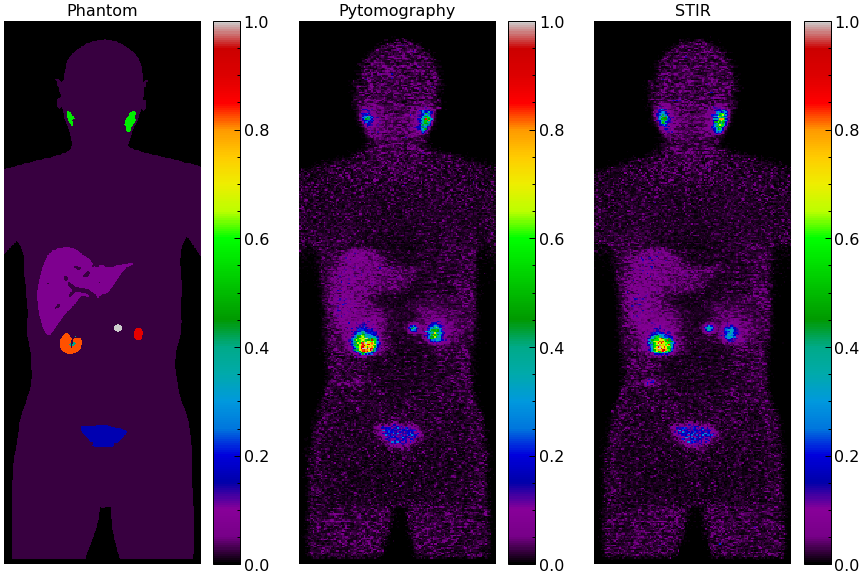

In [82]:
plt.subplots(1,3,figsize=(15,10))
plt.subplot(131)
plt.pcolormesh(GT[:,256].T, cmap='nipy_spectral', vmax=1)
plt.axis('off')
plt.colorbar()
plt.title('Phantom')
plt.subplot(132)
plt.pcolormesh(reconstructed_object[0][:,64].cpu().numpy().T*CPS_to_MBQpermL, cmap='nipy_spectral', vmax=1)
plt.axis('off')
plt.colorbar()
plt.title('Pytomography')
plt.subplot(133)
plt.pcolormesh(data[:,64][::-1,::-1]*CPS_to_MBQpermL, cmap='nipy_spectral', vmax=1)
plt.axis('off')
plt.colorbar()
plt.title('STIR')

plt.show()